#Approximation target comparison for a recurrent neural network based integrator

In [ ]:
import sys
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt
from Code.dynamical_system import *
from Code.time_integrator import *
from Code.neuralnet import *

np.random.seed(2512517)

##Recurrent neural network integrator
This notebook helps determine whether approximating the next state directly outperforms approximating the update and summing with previous state, for a LSTM recurrent neural network based integrator with a $4$-step method. 

Set system parameters, construct dynamical system and integrator.

The model system we are using here is the harmonic oscillator, defined by the equations of motion

$$
\frac{dx}{dt} = v,\qquad\qquad
\frac{dv}{dt} = -\frac{k}{m}x
$$

The timestep size of the Neural network integrator is set to $\Delta t=40\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 2)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 4, 64)             17152     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 52,322
Trainable params: 52,322
Non-trainable params: 0
_________________________________________________________________


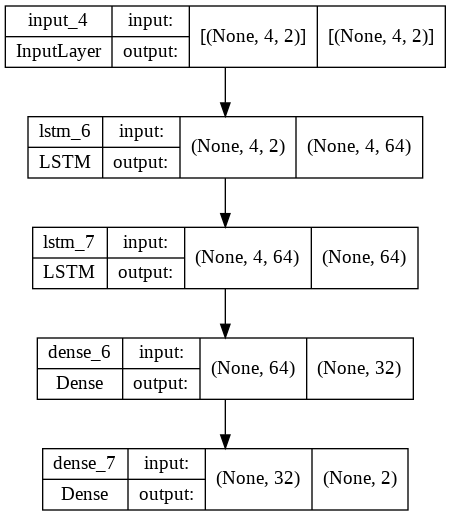

In [ ]:
# mass of particle
mass = 1.2
# spring constant of harmonic oscillator
k_spring = 0.9
# timestep for Verlet integrator
dt_verlet = 0.005
# timestep for neural network integrator
dt = 0.2
# number of steps for neural network integrator
nsteps = 4

harmonic_oscillator = HarmonicOscillator(mass,k_spring)
verlet_integrator = VerletIntegrator(harmonic_oscillator,dt_verlet)
nn_integrator_1 = LSTMFinalIntegrator(harmonic_oscillator,nsteps,dt)
nn_integrator_2 = LSTMStateIntegrator(harmonic_oscillator,nsteps,dt)


# visualise the neural network model
nn_integrator_2.model.summary()
keras.utils.plot_model(nn_integrator_2.model, show_shapes=True)

In [ ]:
BATCH_SIZE=64
data_generator = DataGenerator(nn_integrator_1,verlet_integrator)


train_batches = data_generator.dataset.batch(BATCH_SIZE)



## Train neural network based integrator

In [ ]:
EPOCHS=500
STEPS_PER_EPOCH=150
log_dir = './tb_logs/'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result_1 = nn_integrator_1.model.fit(train_batches,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)
result_2 = nn_integrator_2.model.fit(train_batches,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)


Epoch 1/500
150/150 [==============================] - 22s 126ms/step - loss: 0.0754
Epoch 2/500
150/150 [==============================] - 19s 125ms/step - loss: 0.0130
Epoch 3/500
150/150 [==============================] - 19s 126ms/step - loss: 0.0039
Epoch 4/500
150/150 [==============================] - 19s 129ms/step - loss: 0.0023
Epoch 5/500
150/150 [==============================] - 19s 124ms/step - loss: 0.0014
Epoch 6/500
150/150 [==============================] - 19s 124ms/step - loss: 0.0012
Epoch 7/500
150/150 [==============================] - 18s 123ms/step - loss: 9.8780e-04
Epoch 8/500
150/150 [==============================] - 19s 124ms/step - loss: 7.0448e-04
Epoch 9/500
150/150 [==============================] - 18s 123ms/step - loss: 6.5665e-04
Epoch 10/500
150/150 [==============================] - 19s 125ms/step - loss: 4.6521e-04
Epoch 11/500
150/150 [==============================] - 19s 124ms/step - loss: 4.5484e-04
Epoch 12/500
150/150 [=====================

## Visualise Loss function

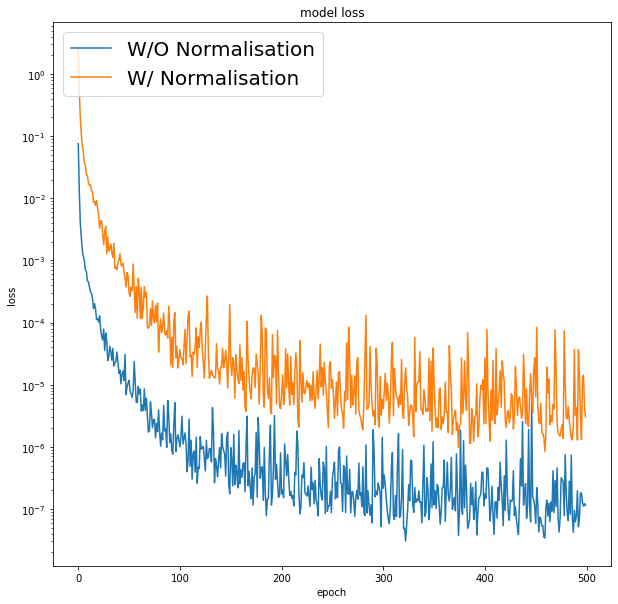

In [ ]:
#print(result.history.keys())

plt.rcParams['figure.figsize'] = [10, 10]

# summarize history for loss
plt.plot(result_1.history['loss'])
plt.plot(result_2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.legend(['W/O Normalisation','W/ Normalisation'], loc='upper left')
plt.yscale("log")
plt.show()

## Plot trajectories to $t=512$ generated by Verlet integrator and neural network based integrator

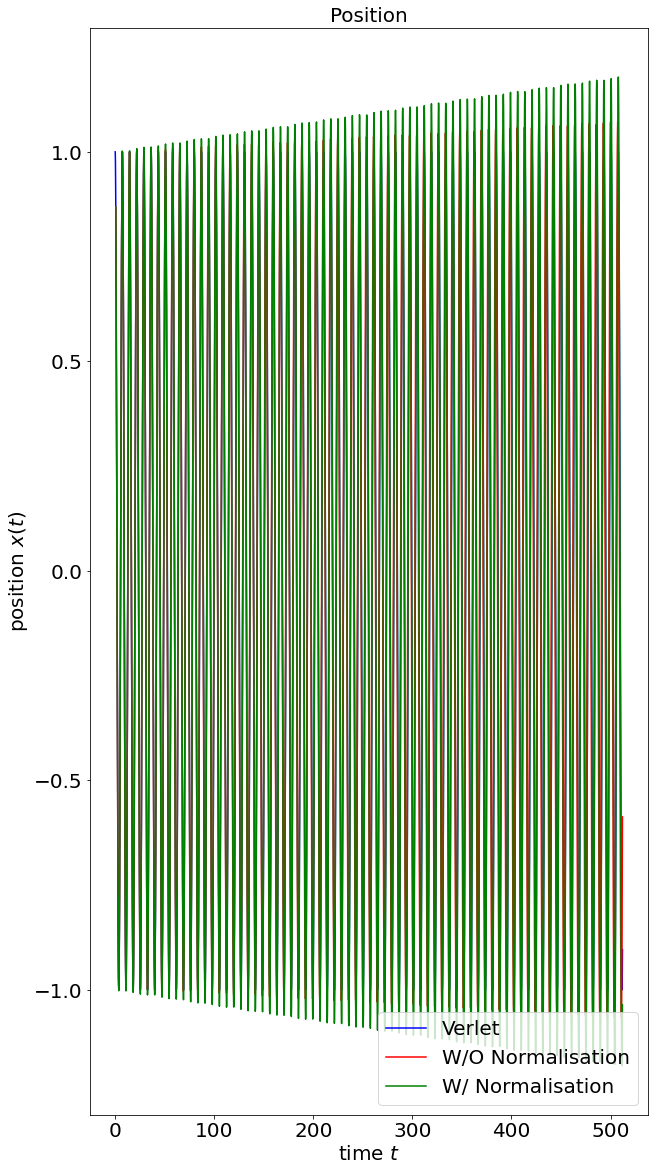

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Unrecognized location 'top left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


<Figure size 720x1440 with 0 Axes>

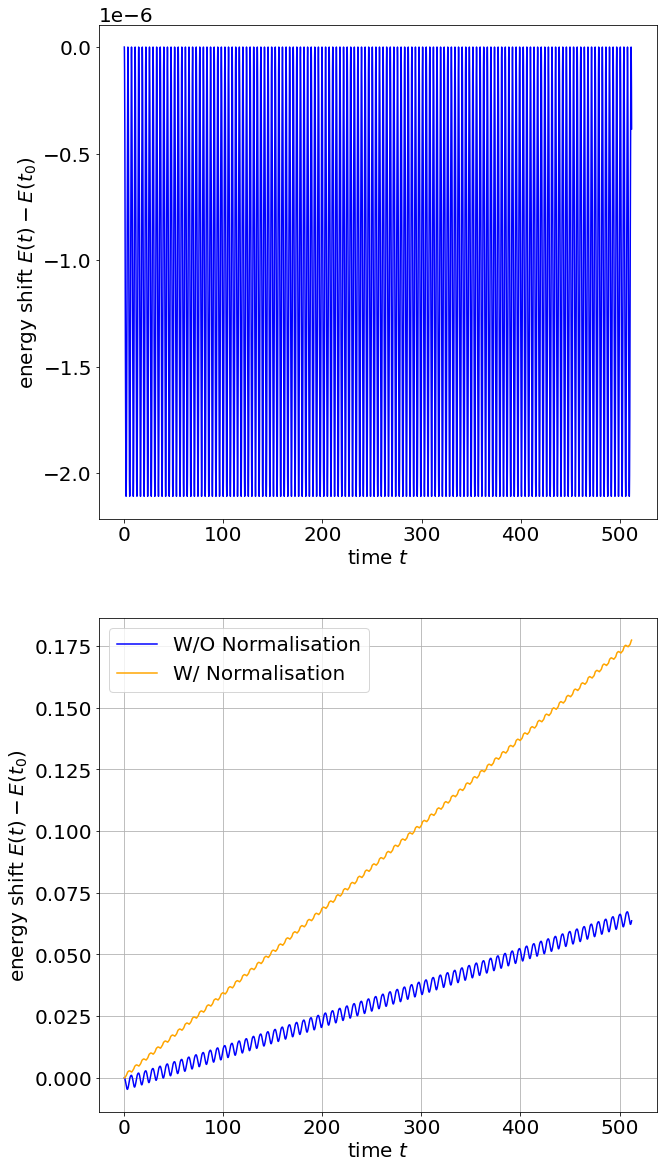

In [ ]:
# Final time
T_final = 512

# Initial conditions
x = np.zeros(1)
v = np.zeros(1)
x[0] = 1.0
v[0] = 0.0
verlet_integrator.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet = []
x_verlet = []
E_verlet = []
while t<T_final:
    t_verlet.append(t)
    E_verlet.append(verlet_integrator.energy())
    x_verlet.append(verlet_integrator.x[0])
    verlet_integrator.integrate(1)
    t += dt_verlet
        

# ==== Neural network integrator ====

# Initialise with Verlet integrator
x_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
v_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
x_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
v_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))


verlet_integrator.set_state(x,v)
for k in range(nn_integrator_1.nsteps):    
    x_initial_1[k,:] = verlet_integrator.x[:]
    v_initial_1[k,:] = verlet_integrator.v[:]
    verlet_integrator.integrate(int(dt/dt_verlet))
verlet_integrator.set_state(x,v)
for k in range(nn_integrator_2.nsteps):    
    x_initial_2[k,:] = verlet_integrator.x[:]
    v_initial_2[k,:] = verlet_integrator.v[:]
    verlet_integrator.integrate(int(dt/dt_verlet))



nn_integrator_1.set_state(x_initial_1,v_initial_1)
t_1 = (nn_integrator_1.nsteps-1)*nn_integrator_1.dt
nn_integrator_2.set_state(x_initial_2,v_initial_2)
t_2 = (nn_integrator_2.nsteps-1)*nn_integrator_2.dt



# Timestepping loop
t_nn_1 = []
x_nn_1 = []
E_nn_1 = []
t_nn_2 = []
x_nn_2 = []
E_nn_2 = []



while t_1<T_final:
    t_nn_1.append(t_1)
    x_nn_1.append(nn_integrator_1.x[0])
    E_nn_1.append(nn_integrator_1.energy())
    nn_integrator_1.integrate(1)
    t_1 += dt
while t_2<T_final:
    t_nn_2.append(t_2)
    x_nn_2.append(nn_integrator_2.x[0])
    E_nn_2.append(nn_integrator_2.energy())
    nn_integrator_2.integrate(1)
    t_2 += dt




# Plot position as a function of time
plt.plot(t_verlet,x_verlet,label='Verlet',color='blue')
plt.plot(t_nn_1,x_nn_1,label='W/O Normalisation',color='red')
plt.plot(t_nn_2,x_nn_2,label='W/ Normalisation',color='green')


plt.legend(loc='lower right')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position $x(t)$')
ax.set_title('Position')
plt.show()

plt.rcParams['figure.figsize'] = [10, 20]

plt.clf()
# Plot energy as a function of time
# (subtract energy at time t=0 to show energy drift)
fig, axs = plt.subplots(2,1)
axs[0].plot(t_verlet,E_verlet-E_verlet[0],label='Verlet',color='blue')
axs[1].plot(t_nn_1,E_nn_1-E_nn_1[0],label='W/O Normalisation',color='blue')
axs[1].plot(t_nn_2,E_nn_2-E_nn_2[0],label='W/ Normalisation',color='orange')

plt.legend(loc='top left')
for ax in axs:
    ax.set_xlabel('time $t$')
    ax.set_ylabel('energy shift $E(t)-E(t_0)$')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.grid()
plt.show()